In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## 1. Set batch size so that GPU memory OOM is avoided

In [3]:
bs=48

## 2. Download the data

This data is laid out in Imagenet style. There are separate train and test folders. There is also a folder `unsup` with unlabelled data which can be used for the language modelling part (but not the actual text classification / sentiment analysis). The README of this dataset is very interesting.

* training set has 12.5k positive and 12.5k negative reviews
  * do they need to be equal? are they really equal in the real world? does it make a difference?
* the rating of the movie associated with a particular review is also given
  * not sure why, is this extra information? the neg/pos class label was sufficient for training.
* any particular movie has at most 30 reviews
  * they mention that no new information can be gained by having lots of reviews. I dont understand the stated reason fully `because reviews for the same movie tend to have correlated ratings`.
* movies in train and test are disjoint.
  * memorizing specific things about a specific movie wont help
* only good or bad movies are included, the neutral ones are not.
  * but in the unsupervised set all movies are included

In [4]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jupyter/.fastai/data/imdb/unsup'),
 PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/databunch_classifier'),
 PosixPath('/home/jupyter/.fastai/data/imdb/models'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README')]

In [5]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg')]

In [6]:
! ls -lh {path}/train

total 61M
-rw-r--r-- 1 jupyter jupyter  21M Apr 12  2011 labeledBow.feat
drwxr-xr-x 2 jupyter jupyter 352K Nov  5  2018 neg
drwxr-xr-x 2 jupyter jupyter 368K Nov  5  2018 pos
-rw-r--r-- 1 jupyter jupyter  40M Apr 12  2011 unsupBow.feat


## 3. Reading the text for language modeling
* `from_folder` - reads all files in the folder recursively.
* `filter_by_folder` - keeps only the relevant files. here even unlabeled data is taken because this is just unsupervised modeling (representational learning) and we can take advantage of all the data we can get.
* `split_by_rand_pct` - creates two dataloaders, one for training and one for validation (randomly with 0.1 probability of being validation item).
* `label_for_lm` - in every epoch it shuffles all sentences, concats them and gives that as input. also does not label the data since labels are unimportant for modeling. 

So suppose there are 3 sentences.
* The tiger is a dangerous animal.
* The elephant is vegan.
* Humans eat anything that moves (and does not move).

Now one hypothetical epoch could be (assuming batch size=4)
* the elephant is vegan
* humans eat anything that
* moves and does not
* move the tiger is
* a dangerous animal

The corresponding expected output that is fed to train the LSTM based network will be:
* elephant is vegan humans
* eat anything that movies
* and does not move
* the tiger is a
* dangerous animal END

In [7]:
data_lm = (TextList.from_folder(path)
           .filter_by_folder(include=['train', 'test', 'unsup'])
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=bs)
          )

## 4. Save the mapping
This helps to avoid slowness due to listing of files, filtering, id assignments etc.
I have not seen much of a problem due to this, so saving is really optional as of now.

In [8]:
data_lm.save("data_lm.pkl")

In [5]:
data_lm = load_data(path, "data_lm.pkl", bs=bs)

In [8]:
data_lm.show_batch()

idx,text
0,"and -- a couple who are jewel thieves . \n \n xxmaj it zings along and is great , amusing , romantic fun . xxbos xxmaj no matter how brilliant and stunning the screenplay would have been , this sequel to ` xxmaj henry , xxmaj portrait of a xxmaj serial xxmaj killer ' was doomed to automatically lose 99 % percent of its power . xxmaj why ?"
1,"a village lass played by xxmaj jenny xxmaj agutter ; they have maybe five or six minutes of conversation ( fully clothed , which is rare for xxmaj agutter ) , whereupon the lass falls so deeply in love with the xxup ira man that she shoots the xxmaj english lout dead and proceeds to betray her fellow villagers -- indeed , her entire country . i suspect that some"
2,"dangerous hit - man , xxmaj john xxmaj turturro , show up the meeting is canceled . xxmaj irène quickly learns that xxmaj elliot has secret information concerning imminent events in the xxup us . xxmaj the meeting is xxunk for xxmaj september 10th in xxmaj venice . xxmaj irène and xxmaj elliot 's children head to xxmaj venice with xxmaj william xxmaj pound in toe for a showdown with"
3,"urban xxmaj legends series , but after loving the first two , for what they were , and this one being directed by xxmaj mary xxmaj lambert ( who i adored for her work with xxmaj madonna and "" xxmaj pet xxmaj xxunk "" ) , i expected a descent movie . \n \n xxmaj not even close . \n \n xxmaj there was no logical reason behind"
4,"a xxmaj trick xxmaj baby . xxmaj it is violent , can be repulsive and disgusting , and is not for everybody . xxmaj but if you like this type of film , this is a great film . xxmaj by all means i recomend it highly , especially if you want to see more of xxmaj jennifer xxmaj tilly than you have before . xxmaj definately an unusal but"


In [9]:
[x for x in data_lm.vocab.stoi.items()][10:15]

[('.', 10), (',', 11), ('and', 12), ('a', 13), ('of', 14)]

In [11]:
data_lm.train_ds[0][0].text[:40]

AttributeError: 'LMTextList' object has no attribute 'sep'

In [11]:
data_lm.train_ds[0][0].data[:10]

array([   2,    5,   20,   16,    9,  139,   14,    9,    5, 4975])

## 5. Create the neural network to learn the language model
Transfer learning is used to allow the movie review based language model to be learnt more easily and quickly. The base weights come from AWD_LSTM trained on a cleaned up version of wikipedia pages called WikiText-103. 

* The input data bunch is provided
* `AWD_LSTM` is a recurrent network with an embedding layer followed by three LSTM layers (with dropouts).
* `drop_mult` - is unclear, seems to be some kind of a common multiplier for all dropout `p` values. So if you ask for 0.4 value of `p` (so that 40% neurons are dropped every training step), then the effective `p` becomes `0.12` thus ensuring not much dropout happens. This is again some Jeremy Howard magic.

#### AWD_LSTM
* `AWD_LSTM` stands for `AWD Long short term memory` neural networks
* `AWD` stands for `ASGD Weight Dropped`. Basically dropout layers are intelligently used even in the recurrent network to provide regularization.
* `ASGD` stands for `Average SGD`. Actually the variant proposed in the paper is called `NT-ASGD` probably for `non-monotonic trigger`
* fast.ai does not seem to use ASGD or NT-ASGD as the paper advises. 
* great resource for understanding the paper https://yashuseth.blog/2018/09/12/awd-lstm-explanation-understanding-language-model/

Great quote from Jeremy Howard
> So getting really good at training language models is a great way to teach a neural-net a lot about what is our world, what's in our world, how do things work in our world. It's a really fascinating topic

In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [13]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [15]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 60000]          24,060,000 True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 24,060,000
Total trainable params: 24,060,000
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss fu

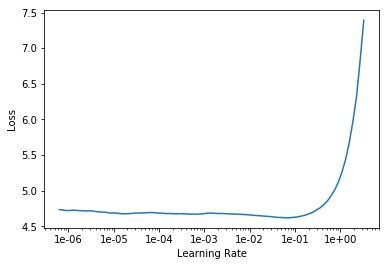

In [16]:
learn.recorder.plot()

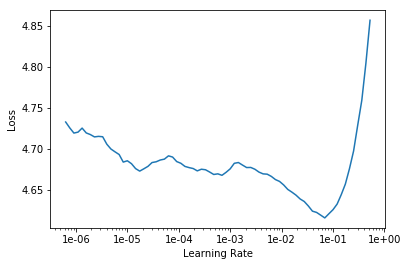

In [17]:
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.168975,4.028216,0.295077,49:49


In [19]:
learn.save('lm-1')
learn.load('lm-1');

In [7]:
learn.load('lm-1');

In [8]:
learn.unfreeze()

In [9]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.842488,3.785374,0.323664,56:39
1,3.664498,3.692333,0.335146,56:48


In [10]:
learn.save("lm-2")

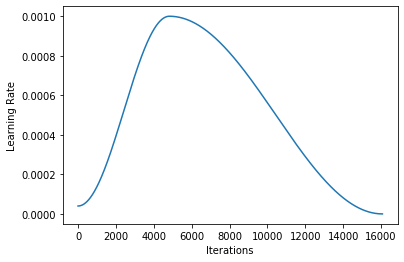

In [13]:
learn.recorder.plot_lr()

In [7]:
learn.load("lm-2");

In [8]:
learn.predict("I liked this movie because ", 100, temperature=1.1, min_p=0.001)

"I liked this movie because  Wesley 's acting was always on the serious side . He would say he 's the most entertaining of the cast . He 's also the only man in the film that did n't look very dangerous for Boris Karloff and probably even his show had him on his side . In the end the story starts ( though we think it started to drag a second ) and at one point they come a second while in the hospital where they just 've worked over a week before . They have their"

In [17]:
learn.save_encoder("lm-2-encoder")

In [20]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))
data_clas.save('databunch_classifier')

In [9]:
data_clas = load_data(path, 'databunch_classifier', bs=24)

In [23]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of oatmeal . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",neg
"xxbos xxmaj pier xxmaj paolo xxmaj pasolini , or xxmaj pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated xxmaj european xxmaj marxist director - and they are thick on the ground . xxmaj how anyone can see "" art "" in this messy , cheap sex - romp concoction is",neg
"xxbos xxup oliver xxup twist was to have controversy as well as success following it after xxmaj dickens published it in 1837 . xxmaj his picture of life in the urban ghettos was something shocking and new , and his making the central figures of the novel include criminals was another innovation . \n \n xxmaj one day he was walking in xxmaj london and passed a young woman",pos
"xxbos xxmaj this was the second of two filmed "" xxmaj hamlets "" in the nineties , the first being xxmaj franco xxmaj zeffirelli 's , starring xxmaj mel xxmaj gibson , from 1990 . xxmaj zeffirelli 's version , like xxmaj laurence xxmaj olivier 's from 1948 , was based upon an abridged version of the play , with much of xxmaj shakespeare 's original text being cut .",pos


In [10]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_clas.load_encoder('lm-2-encoder')
learn_clas.freeze()

In [25]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


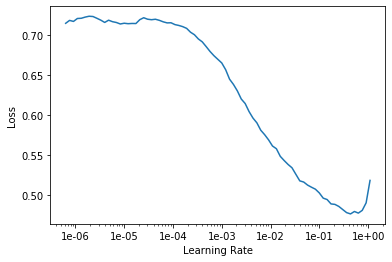

In [26]:
learn_clas.recorder.plot()

In [27]:
learn_clas.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.290054,0.211483,0.917480,05:36


In [28]:
learn_clas.save("m-1")
learn_clas.load("m-1");

In [29]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.226586,0.175799,0.932000,05:59


In [30]:
learn_clas.save("m-2")
learn_clas.load("m-2");

In [11]:
learn_clas.load("m-2");

In [12]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.205010,0.151711,0.942360,12:16


In [13]:
learn_clas.save("m-3")
learn_clas.load("m-3");

In [14]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 52.00 MiB (GPU 0; 7.43 GiB total capacity; 6.54 GiB already allocated; 21.94 MiB free; 393.91 MiB cached)

In [ ]:
learn_clas.save("m-4")
learn_clas.load("m-4");

In [16]:
learn_clas.predict("I really hated that movie, it was bad!")

(Category neg, tensor(0), tensor([0.9932, 0.0068]))

In [17]:
learn_clas.predict("That movie was not bad at all")

(Category neg, tensor(0), tensor([0.6099, 0.3901]))

In [18]:
learn_clas.predict("I really loved that movie, it was great!")

(Category pos, tensor(1), tensor([0.0019, 0.9981]))

In [19]:
learn_clas.predict("Not the brightest one here")

(Category neg, tensor(0), tensor([0.7228, 0.2772]))